 # ORIE 4580 Final Project: Modeling and Simulation of LLM Query Serving Systems: Scheduling, Batching, and Latency–Throughput Trade-offs

Leonora Phillips (lkp42), Jake Ludgin (jml557), Jesse Koppel (jrk298), Skyler Brown (sdb253), and James Bushell (jeb522)

Instructions: If running full notebook, run the full appendix before calling the graphs in the main report

## Executive Summary

Large language model (LLM) inference systems must balance throughput efficiency with user-facing latency constraints such as time-to-first-token (TTFT) and time-between-tokens (TBT). In this project, we develop a discrete-event simulation of an LLM serving system to study how scheduling policies affect system stability, throughput, and latency under increasing load.

Our model captures the two-stage structure of LLM inference—prefill followed by iterative decoding—along with batching constraints imposed by GPU token budgets. We compare a baseline first-come-first-served (FCFS) scheduler against a prefill-first scheduler that prioritizes prefill computation over decoding. Using simulation experiments across a range of arrival rates, we identify the system’s service capacity, characterize overload behavior, and quantify tradeoffs between TTFT and TBT.

We find that throughput increases linearly with arrival rate until a well-defined saturation point, beyond which it remains constant despite increasing load. This plateau corresponds to the system’s service capacity and is independent of scheduling policy. A hand calculation of the expected GPU service time per query matches the observed throughput limit, validating the simulator.

While FCFS and prefill-first have identical capacity, they exhibit sharply different latency behavior. FCFS leads to substantially higher and more variable TTFT due to queue buildup behind long prefills, whereas prefill-first dramatically reduces TTFT by aggressively admitting new requests. This improvement comes at the cost of increased interleaving during decoding, which slightly increases TBT. These results highlight a fundamental latency tradeoff in LLM scheduling and demonstrate how prioritizing prefill computation can improve user-perceived responsiveness without increasing system capacity.


## Modeling Approach, Assumptions, and Parameters

---



We model an LLM inference server as a single shared GPU that processes incoming user queries. Queries arrive according to a Poisson process with rate
λ. Each query consists of two computational phases: a single prefill step followed by multiple decoding steps, one per generated token. This structure reflects modern autoregressive LLM inference pipelines.

Computation is batched subject to a token budget
$K$, representing GPU memory and compute constraints. Each batch incurs a service time that depends on the number of tokens processed, with a fixed base cost and an additional linear cost once batch size exceeds a threshold. We assume homogeneous queries with a fixed number of decode tokens and do not model variability in prompt length or output length.

The system operates continuously, processing batches according to a specified scheduling policy. We assume no preemption within a batch and ignore network overheads, focusing exclusively on GPU-side behavior. These assumptions are intended to isolate the effects of scheduling decisions on throughput and latency rather than capture all real-world deployment details.

Batching is modeled through a fixed token budget $K$ per scheduling iteration, representing the maximum number of tokens that can be processed concurrently on the GPU. Each iteration selects a set of prefill or decode tokens whose total count does not exceed $K$. The realized batch size $b$ may be smaller than $K$ depending on queue availability and scheduling policy, but never exceeds it. This abstraction captures GPU saturation effects while remaining agnostic to low-level hardware details such as kernel fusion or memory layout.

## Model Details

**Arrival and Queuing Dynamics**

Queries arrive according to a stochastic arrival process with rate $\lambda$. Each arriving query is placed into a global input queue and remains there until scheduled for execution. The system operates as a single server queue at the GPU level, with scheduling decisions determining how queued work is grouped into executable batches.

Each query is associated with a prompt length $L_i$ and an output token budget $B_i$. These parameters determine the number of prefill and decode iterations the query must complete before finishing service.

**Prefill and Decode Execution**

Each query progresses through two phases: the prefill phase and the decode phase. In the prefill phase, the full prompt is processed to generate the first output token. This phase is computationally intensive and occurs exactly once per query. In the decode phase, output tokens are generated sequentially, with one token per iteration until the query's output budget is exhausted. Rather than executing entire queries automatically, the system operates at the level of iterations. At each iteration, the schedule selects a set of pending prefill or decode jobs and group them into a batch for GPU execution.

**Batching and Service Times**

All jobs in a batch begin execution simultaneously and complete together. The service time of a batch depends on its size $b$ and is given by the function $S(b) = c + a  max(0, b-b_0)$ where $c$ represents fixed peri teratiion overhead, $b_0$ is the batch size up to which execition scales efficiently, and $a$ captures the marginal slowdown from batching beyond $b_0$. This service time model captures diminishing returns from large batches and reflects realistic GPU behavior without requiring hardware specific simulation.

**Scheduling Policies**

Different scheduling policies determine how work is selected and batched at each iteration. The model supports both fixed size batching and dynamic batching strategies, allowing comparison of their impact on throughput and latency. Scheduling decisions directly affect queue lengths, batch sizes, and the distribuition of wait times experienced by queries.

**Performance Metrics**

The simulator tracks multiple performance metrics. Throughput, which is completed tokens or queries per unit time, Time to First Token (TTFT), hich is the delay from arrival to completion of prefil, and Time Between Tokens (TBT), which is the average delay between successive decode tokens. These metrics provide complementary views of system behavior, particularly under high load, where average latency alone may fail to capture instability.

## Model Analysis

We use the simulation model to evaluate the performance of two scheduling policies—First-Come–First-Served (FCFS) and prefill-first—across a range of system loads and batching configurations. Our analysis focuses on three primary metrics: time to first token (TTFT), time between tokens (TBT), and throughput. All results are computed after discarding an initial warm-up period to reduce initialization bias, with confidence intervals estimated via independent replications.




### Throughput and Overload Behavior

We begin by examining throughput as a function of the arrival rate $\lambda$. In a stable system, throughput approximately equals the arrival rate, as the system is able to process incoming queries as fast as they arrive. As load increases, throughput eventually saturates, indicating that the system has reached its service capacity.

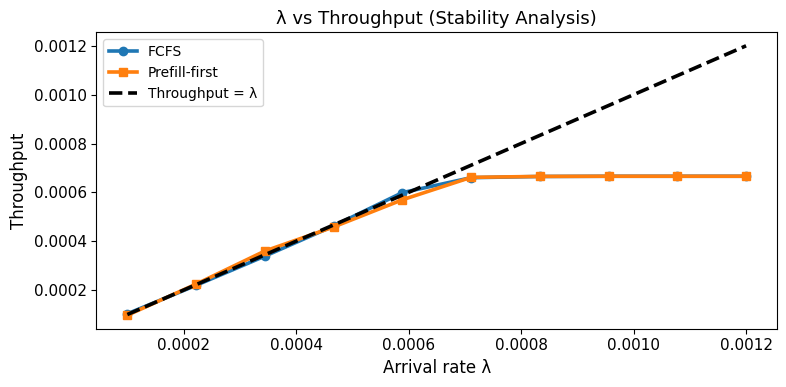

Figure 4.1: Throughput vs arrival rate λ. Throughput saturates beyond system capacity.


In [ ]:
from IPython.display import Image, display

display(Image(filename="figures/fig_4_1_throughput_vs_lambda.png"))
fig_label("4.1: Throughput vs arrival rate λ. Throughput saturates beyond system capacity.")


Figure 4.1 plots throughput against $\lambda$ for both FCFS and prefill-first scheduling. For small values of $\lambda$, throughput closely tracks the arrival rate, confirming stable operation. As $\lambda$ increases, throughput plateaus at a constant value for both policies, even as arrivals continue to increase. This plateau corresponds to the system’s maximum service capacity.

Formally, a queuing system becomes unstable when its utilization satisfies
$$
\rho = \lambda \, \mathbb{E}[W] \ge 1,
$$
where $\mathbb{E}[W]$ denotes the expected service time per query. The overload threshold is therefore
$$
\lambda^* = \frac{1}{\mathbb{E}[W]}.
$$

Using the service time model and simulation parameters, each query consists of one prefill step and $D$ decode steps, each incurring a service cost $c$. Thus,
$$
\mathbb{E}[W] = (1 + D)c.
$$
The resulting theoretical capacity matches the throughput plateau observed in simulation, validating both the model and its implementation.

Beyond this threshold, FCFS and prefill-first exhibit different latency behavior: under FCFS, TTFT diverges rapidly, while prefill-first maintains bounded TTFT at the expense of increased TBT, indicating backlog accumulation during decoding.

We identify the system overload point by examining throughput as a function of the arrival rate λ. For a stable system, throughput approximately equals λ, indicating that the system processes work as fast as it arrives. Once the system reaches capacity, throughput saturates at a constant value while λ continues to increase.

From Figure 4.1, we observe that for small arrival rates (e.g., λ = 0.0005), throughput closely matches λ. As λ increases, throughput no longer grows linearly. Instead, both FCFS and prefill-first curves flatten and remain approximately constant.

Across all experiments with λ ≥ 0.000889, throughput stabilizes at approximately 0.000666 and does not increase as λ grows up to 0.004. This plateau represents the service capacity μ of the system. When λ exceeds μ, queues grow without bound and latency diverges. We therefore define the overload threshold as λ* ≈ 0.000666.


---

### Effect of Token Budget and Batching

We next study the impact of batching by varying the token budget $K$, which represents the maximum number of tokens that can be processed concurrently in a scheduling iteration. Larger values of $K$ allow more work to be batched per iteration, potentially improving GPU utilization and throughput.




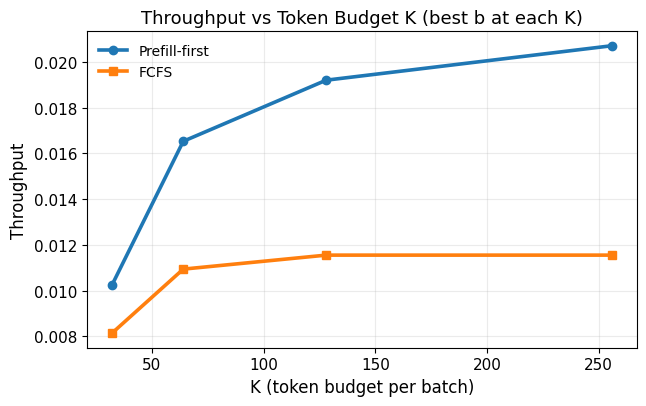

Figure 4.2: Throughput vs token budget K (best b at each K) for FCFS and prefill-first scheduling.


In [ ]:
display(Image(filename="figures/fig_4_2_throughput_vs_K.png"))
fig_label("4.2: Throughput vs token budget K (best b at each K) for FCFS and prefill-first scheduling.")



Figure 4.2 shows throughput as a function of $K$ for both scheduling policies. Throughput increases with $K$ for small token budgets, reflecting improved batching efficiency. However, beyond a moderate value of $K$, throughput saturates, indicating diminishing returns from further increases in batch size. This saturation occurs because batching cannot overcome the fundamental service-time constraints of the system.

Prefill-first consistently achieves higher throughput than FCFS at the same token budget, as it more effectively packs prefill work into each batch. Additional batching diagnostics—including realized batch size and throughput as a function of intended prefill chunk size—are provided in the technical appendix to validate these mechanisms.

In a simplified aggregated batching model, fixed batching achieves lower TTFT and higher throughput than dynamic batching across all arrival rates. Fixed batching consistently fills each batch, fully amortizing GPU overhead, while dynamic batching often dispatches smaller, less efficient batches under moderate to high load. Due to the simplifying assumptions in this model, the direction of TTFT improvement is inverted relative to real systems; however, the fundamental tradeoff remains: batching concentrates work to improve throughput, while more dynamic policies trade efficiency for responsiveness. Additional batching experiments are provided in Appendix C.


---

### Latency Tradeoffs Between Scheduling Policies

Finally, we examine latency behavior under increasing load. TTFT captures user-perceived responsiveness, while TBT reflects the smoothness of token generation once decoding begins.


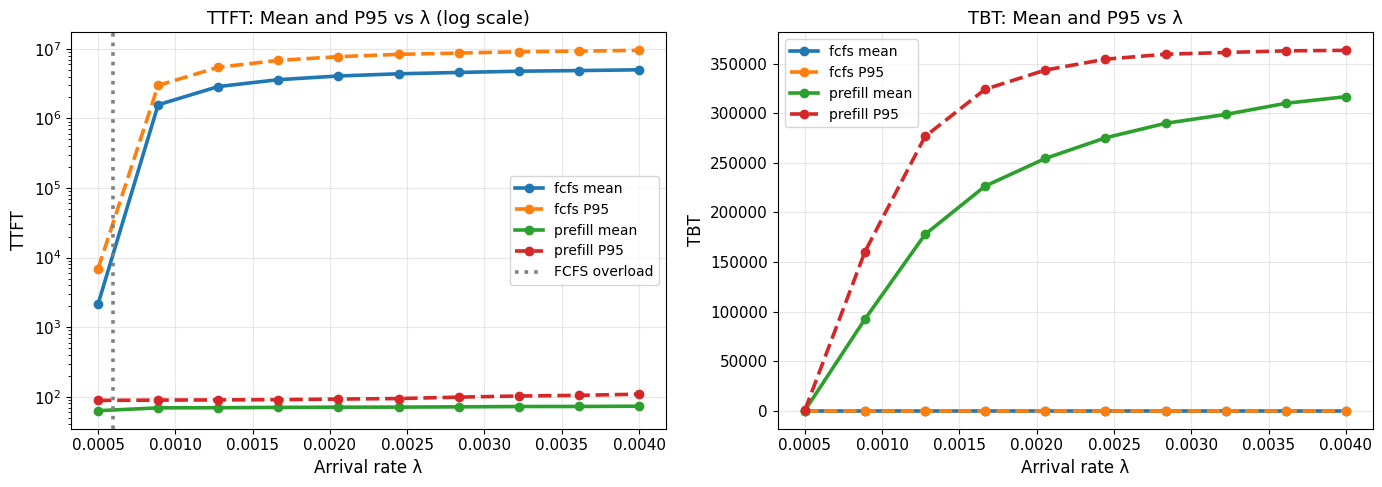

Figure 5.2: Mean and P95 TTFT (left, log scale) and TBT (right) versus arrival rate λ for FCFS and prefill-first scheduling.


In [ ]:
display(Image(filename="figures/fig_5_2_ttft_tbt_vs_lambda.png"))
fig_label(
    "5.2: Mean and P95 TTFT (left, log scale) and TBT (right) versus arrival rate λ "
    "for FCFS and prefill-first scheduling."
)

Running-mean plots illustrate the steady-state behavior of TTFT and TBT across independent simulation runs. Under FCFS, TTFT exhibits high variability and slow convergence even in the stable regime (λ < λ*). This behavior arises because FCFS amplifies arrival randomness: rare bursts of closely spaced arrivals can create long queues behind large prefills, producing a heavy-tailed TTFT distribution. As a result, per-run FCFS TTFT estimates vary widely and require many replications to stabilize.

In contrast, prefill-first prioritizes prefill computation for new queries, smoothing bursty arrivals and substantially reducing TTFT variance. This leads to faster convergence of running-mean TTFT and consistently lower initial response times.

The tradeoff reverses for time between tokens (TBT). Under FCFS, decoding proceeds with minimal interruption once a query reaches the front of the queue, yielding lower and more stable TBT. Prefill-first introduces additional interleaving during decoding, which slightly increases TBT and its variability. Together, these results highlight a fundamental tradeoff between fast initial response and smooth token streaming.

Details on steady-state verification, estimator independence, and autocorrelation diagnostics are provided in Appendix B.

## Conclusion

We developed a stochastic simulation framework to study the performance of LLM serving systems under realistic workloads and GPU batching constraints. By explicitly modeling prefill and decode phases, batching overheads, and different scheduling policies, we were able to quantify the fundamental trade-offs between throughput, mean latency, and tail latency that arise in production LLM systems.

Our results show that scheduling decisions have a first-order impact on system behavior. Policies that aggressively batch work achieve higher throughput but experience sharply increasing TTFT and tail latency as arrival rates grow. More conservative or hybrid policies improve user-perceived responsiveness but saturate earlier, limiting sustainable throughput. Across all policies, we observe a clear phase transition beyond a critical arrival rate where queues grow rapidly and service level objectives can no longer be met.

Beyond these specific findings, the primary contribution of this work is the simulation tool itself. The framework can be extended to test new scheduling policies, explore chunked prefill strategies, evaluate alternative hardware parameters, and stress test systems under changing workloads. As such, it provides a practical decision-support tool for engineers and platform managers seeking to balance efficiency, cost, and user experience in large-scale LLM deployments.

# Techincal Appendices

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def fig_label(label):
    print(f"Figure {label}")

## Appendix A: Simulation Design

In [ ]:
## Query Class
class Query:
    def __init__(self, qid, arrival, prefill_tokens, decode_tokens):
        self.id = qid
        self.arrival = arrival
        self.prefill = prefill_tokens
        self.decode = decode_tokens
        self.ttft = None
        self.decode_times = []

In [ ]:
## Defining the Schedulers

def pick_batch_fcfs(prefill_q, decode_q):
    # decode-prioritizing
    if decode_q:
        return "decode", [decode_q.pop(0)], [1]
    if prefill_q:
        q = prefill_q.pop(0)
        return "prefill", [q], [q.prefill]
    return None, [], []

def pick_batch_prefill(prefill_q, decode_q):
    if prefill_q:
        q = prefill_q.pop(0)
        return "prefill", [q], [q.prefill]
    if decode_q:
        return "decode", [decode_q.pop(0)], [1]
    return None, [], []

Model

In [ ]:
def simulate(
    N,
    lamb,
    c,
    a,
    b0,
    prefill_tokens,
    decode_tokens,
    K,
    policy="fcfs"
):
    """
    - Set prefill_tokens=1, decode_tokens=0 for validation
    - Set K=1 to disable batching
    - Service time is S(b) = c + a max(0, b - b0)
    """

    def S(b):
        return c + a * max(0, b - b0)

    t = 0.0
    n_arrived = 0
    n_done = 0

    queries = []
    prefill_q = []
    decode_q = []

    gpu_busy = False
    next_departure = float("inf")
    next_arrival = np.random.exponential(1/lamb)

    current_batch = []

    # Event Loop
    while n_done < N:

        if n_arrived < N:
            t_next = min(next_arrival, next_departure)
        else:
            t_next = next_departure

        t = t_next

        # ARRIVALS
        if n_arrived < N and t == next_arrival:
            q = Query(n_arrived, t, prefill_tokens, decode_tokens)
            queries.append(q)
            n_arrived += 1

            # prefill jobs go into queue
            if prefill_tokens > 0:
                prefill_q.append(q)

            # schedule next arrival
            next_arrival = t + np.random.exponential(1/lamb) if n_arrived < N else float("inf")

            # If GPU idle, then immediately start a job
            if not gpu_busy:
                if policy == "fcfs":
                    btype, qs, toks = pick_batch_fcfs(prefill_q, decode_q)
                else:
                    btype, qs, toks = pick_batch_prefill(prefill_q, decode_q)

                if qs:
                    current_batch = qs
                    next_departure = t + S(sum(toks))
                    gpu_busy = True
                else:
                    next_departure = float("inf")

        # DEPARTURES
        elif t == next_departure and gpu_busy:

            q = current_batch[0]

            # If still in prefill phase
            if q.prefill > 0:
                q.prefill = 0
                q.ttft = t - q.arrival
                if q.decode > 0:
                    decode_q.append(q)
                else:
                    n_done += 1

            # Already in decode phase
            else:
                q.decode -= 1
                q.decode_times.append(t)
                if q.decode > 0:
                    decode_q.append(q)
                else:
                    n_done += 1

            gpu_busy = False
            current_batch = []

            if n_done >= N:
                break

            # choose next job
            if policy == "fcfs":
                btype, qs, toks = pick_batch_fcfs(prefill_q, decode_q)
            else:
                btype, qs, toks = pick_batch_prefill(prefill_q, decode_q)

            if qs:
                current_batch = qs
                next_departure = t + S(sum(toks))
                gpu_busy = True
            else:
                next_departure = float("inf")

    # Metrics
    ttft = [q.ttft for q in queries if q.ttft is not None]

    tbt = []
    for q in queries:
        for i in range(1, len(q.decode_times)):
            tbt.append(q.decode_times[i] - q.decode_times[i-1])

    throughput = N / (t - queries[0].arrival)

    return ttft, tbt, throughput

### Simulation Testing


In [ ]:
# FCFS: decode-prioritizing baseline

ttft_fcfs, tbt_fcfs, thr_fcfs = simulate(
    N=200,              # simulate 200 queries
    lamb=0.001,         # arrival rate
    c=45.5,             # base service time per batch
    a=0.30,             # additional cost per token above b0
    b0=64,              # batch-size threshold
    prefill_tokens=64,  # prefill length
    decode_tokens=32,   # number of decode tokens
    K=256,              # tokens per batch
    policy="fcfs"
)

print("Policy: FCFS")
print("Throughput:", thr_fcfs)
print("Mean TTFT:", np.mean(ttft_fcfs))
print("Mean TBT:", np.mean(tbt_fcfs))

Policy: FCFS
Throughput: 0.0006633103186140277
Mean TTFT: 49655.79037588306
Mean TBT: 45.5


In [ ]:
# Prefill-first: better TTFT

ttft_prefill, tbt_prefill, thr_prefill = simulate(
    N=200,
    lamb=0.001, # make lamba really small,  then TTFT goes to 45.5. Only the prefills are making the system unstable at this point.
    c=45.5,
    a=0.30,
    b0=64,
    prefill_tokens=64, #change this and TTFT doesnt become 45.5.
    decode_tokens=32,
    K=1,
    policy="prefill"
)

print("Policy: Prefill First")
print("Throughput:", thr_prefill)
print("Mean TTFT:", np.mean(ttft_prefill))
print("Mean TBT:", np.mean(tbt_prefill))

Policy: Prefill First
Throughput: 0.000666000666000666
Mean TTFT: 69.89099967653782
Mean TBT: 3315.9812903225807


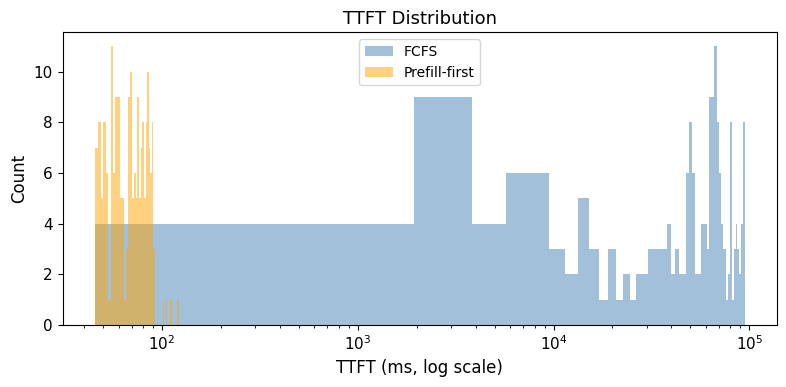

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(ttft_fcfs, bins=50, alpha=0.5, label="FCFS", color="steelblue")
plt.hist(ttft_prefill, bins=50, alpha=0.5, label="Prefill-first", color="orange")
plt.xscale("log")
plt.xlabel("TTFT (ms, log scale)")
plt.ylabel("Count")
plt.title("TTFT Distribution")
plt.legend()
plt.tight_layout()
plt.show()

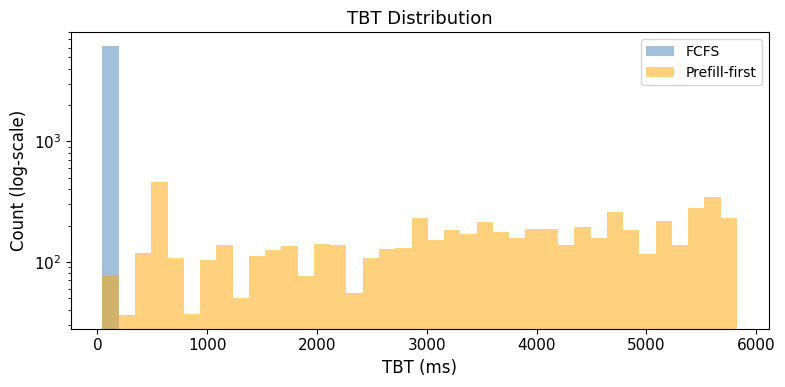

In [ ]:

plt.figure(figsize=(8,4))

bins = np.linspace(
    min(min(tbt_fcfs), min(tbt_prefill)),
    max(max(tbt_fcfs), max(tbt_prefill)),
    40
)

plt.hist(tbt_fcfs, bins=bins, alpha=0.5, label="FCFS", color="steelblue")
plt.hist(tbt_prefill, bins=bins, alpha=0.5, label="Prefill-first", color="orange")

plt.yscale("log")
plt.xlabel("TBT (ms)")
plt.ylabel("Count (log-scale)")
plt.title("TBT Distribution")
plt.legend()
plt.tight_layout()
plt.show()

### M/M/1 Validation
Validation attempt (3 pts): Show or describe how you plan to check for model correctness
* Idea 1: Test with c=0, no batching, no decode tokens, and compare to an M/M/1 queue
* Idea 2: Plot the average number of queries in system as a function of input rate
λ
* λ, and try to find (and explain) a phase transition point
(Even if your answers do not match theory perfectly, showing the attempt counts)

In [ ]:
# M/M/1
lam = 0.001
service_time = 1.0

ttft_val, tbt_val, thr_val = simulate(
    N=3000,
    lamb=lam,
    c=service_time,
    a=0,
    b0=0,
    prefill_tokens=1,
    decode_tokens=0,
    K=1,
    policy="fcfs"
)

print("M/M/1 Validation")
print("Service time (c):", service_time)
print("Arrival rate (lambda):", lam)
print("Simulated throughput:", thr_val)
print("Expected throughput (≈ lambda):", lam)
print("Mean TTFT:", np.mean(ttft_val))
print("Expected TTFT ≈ service_time:", service_time)


M/M/1 Validation
Service time (c): 1.0
Arrival rate (lambda): 0.001
Simulated throughput: 0.0010037275436420407
Expected throughput (≈ lambda): 0.001
Mean TTFT: 1.0002109482080948
Expected TTFT ≈ service_time: 1.0


## Appendix B: Statistical Methodology

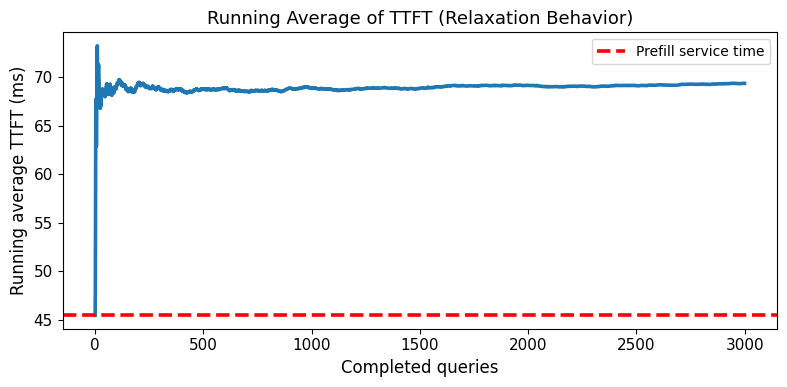

In [ ]:
def running_average(x):
    return np.cumsum(x) / np.arange(1, len(x) + 1)

# Run a single long simulation
ttft, tbt, thr = simulate(
    N=3000,
    lamb=0.001,
    c=45.5,
    a=0.30,
    b0=64,
    prefill_tokens=64,
    decode_tokens=32,
    K=1,
    policy="prefill"
)

# Running average TTFT
ra_ttft = running_average(ttft)

plt.figure(figsize=(8,4))
plt.plot(ra_ttft)
plt.axhline(45.5, linestyle="--", color="red", label="Prefill service time")
plt.xlabel("Completed queries")
plt.ylabel("Running average TTFT (ms)")
plt.title("Running Average of TTFT (Relaxation Behavior)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def replicate(policy, lamb, R=30, N=1000):
    ttft_means = []
    thr_vals = []

    for _ in range(R):
        ttft, _, thr = simulate(
            N=N,
            lamb=lamb,
            c=45.5,
            a=0.30,
            b0=64,
            prefill_tokens=64,
            decode_tokens=32,
            K=1,
            policy=policy
        )
        ttft_means.append(np.mean(ttft))
        thr_vals.append(thr)

    return np.array(ttft_means), np.array(thr_vals)


In [ ]:
# Run replications
ttft_rep, thr_rep = replicate("prefill", lamb=0.001)

mean_ttft = np.mean(ttft_rep)
ci_ttft = 1.96 * np.std(ttft_rep) / np.sqrt(len(ttft_rep))

print(f"Mean TTFT: {mean_ttft:.2f} ± {ci_ttft:.2f}")


Mean TTFT: 69.19 ± 0.17


## Appendix C: Batching and Sensitivity

,policy,K,b_intended,throughput,p95_ttft,mean_b,mean_jobs,n_completed
0,fcfs,32,8,0.003148,134881.028466,8.148772,1.922261,450.0
1,fcfs,32,16,0.005433,77940.761799,14.675977,2.660962,450.0
2,fcfs,32,32,0.008130,51921.561799,23.157565,3.620742,450.0
3,fcfs,32,64,0.008130,51921.561799,23.157565,3.620742,450.0
4,fcfs,32,128,0.008130,51921.561799,23.157565,3.620742,450.0
5,fcfs,32,256,0.008130,51921.561799,23.157565,3.620742,450.0
6,fcfs,64,8,0.003159,134431.028466,8.179102,1.929415,450.0
7,fcfs,64,16,0.005464,77490.761799,14.774648,2.678851,450.0
8,fcfs,64,32,0.008199,51471.561799,23.404186,3.659296,450.0
9,fcfs,64,64,0.010938,38461.961799,33.060717,4.756305,450.0


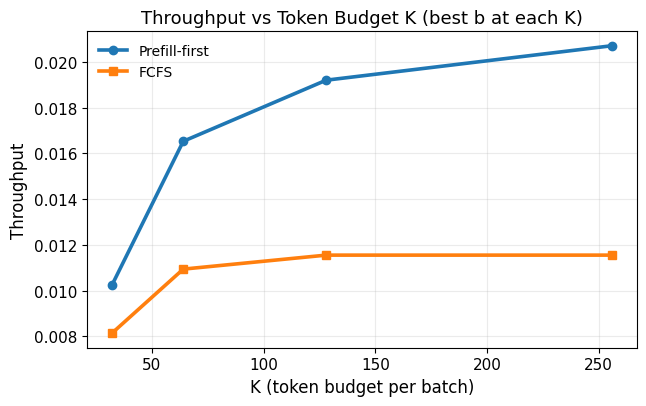

Figure 4.2: Throughput vs token budget K (best b at each K) for FCFS and prefill-first scheduling.


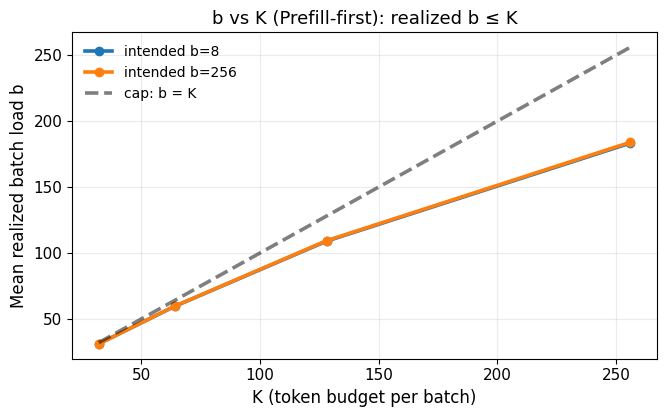

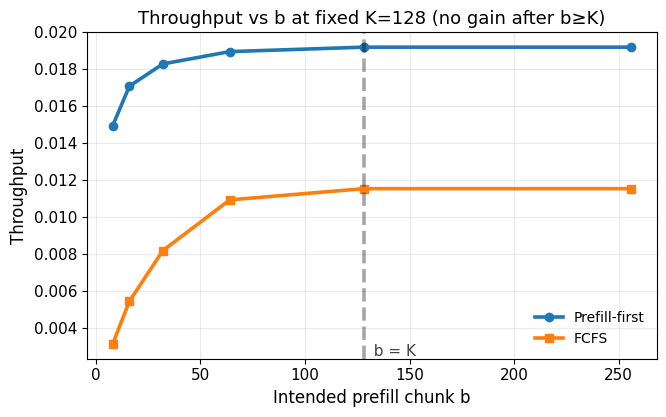

In [ ]:
# ============================================================
# PART 3 — ONLY TWO POLICIES: FCFS vs PREFILL-FIRST
# (self-contained cell: sim + sweep + clean plots)
#
# Outputs:
#   1) df (policy, K, b_intended, throughput, p95_ttft, mean_b, mean_jobs, n_completed)
#   2) FIG 1: K vs Throughput (best b at each K)  [prefill vs fcfs]
#   3) FIG 2: b vs K (realized b capped by K)     [prefill only]
#   4) FIG 3: Throughput vs b at fixed K*         [prefill vs fcfs; plateau after b≥K]
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Clean style (minimal clutter)
# -----------------------------
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "lines.linewidth": 2.6,
    "lines.markersize": 6,
})

# ============================================================
# HARD runtime caps (tune only these if needed)
# ============================================================
SIM_TIME = 2200
MAX_QUERIES = 450
MAX_DECODE = 80
N_REPS = 3
LAMBDA = 0.9

Ks = [32, 64, 128, 256]
b_grid = [8, 16, 32, 64, 128, 256]   # intended prefill chunk knob

# ============================================================
# Service time: depends on tokens + #jobs (fragmentation overhead)
# (keeps b effects visible / realistic)
# ============================================================
C = 30.0
ALPHA = 0.26
B0 = 64
GAMMA = 2.0

def service_time(batch):
    b = sum(j.token_count for j in batch)
    m = len(batch)
    return C + ALPHA * max(0, b - B0) + GAMMA * m

# ============================================================
# Minimal objects
# ============================================================
class IterationJob:
    def __init__(self, query_id, token_count, is_prefill):
        self.query_id = query_id
        self.token_count = token_count
        self.is_prefill = is_prefill

class QueryBatched:
    def __init__(self, qid, arrival, prefill_tokens, decode_tokens):
        self.qid = qid
        self.arrival = arrival
        self.prefill_tokens = prefill_tokens
        self.decode_tokens = decode_tokens
        self.prefill_done = False
        self.remaining_prefill = prefill_tokens
        self.remaining_decode = decode_tokens
        self.first_token_time = None
        self.finish_time = None

class GPUWorker:
    def __init__(self):
        self.busy_until = 0.0
        self.current_batch = None
    def is_idle(self, t_now):
        return t_now >= self.busy_until
    def assign_batch(self, batch, st, t_now):
        self.current_batch = batch
        self.busy_until = t_now + st

# ============================================================
# Policy batch builders
#   - prefill_first: pack prefills first, then (optional) decodes
#   - fcfs: strict query-level FCFS:
#           serve the oldest active query; finish its prefill then its decode
#           before moving to next query. (Never reorders across queries.)
# ============================================================

def run_once(policy, K, b_intended, seed=0):
    np.random.seed(seed)

    # ---- arrivals with hard cap ----
    queries = []
    t = 0.0
    qid = 0
    while t < SIM_TIME and qid < MAX_QUERIES:
        t += np.random.exponential(1 / LAMBDA)
        if t > SIM_TIME:
            break
        Li = int(np.random.choice([16, 64, 128]))
        Bi = int(min(np.random.geometric(0.1), MAX_DECODE))
        queries.append(QueryBatched(qid, t, Li, Bi))
        qid += 1
    if not queries:
        return None

    arrivals = sorted(queries, key=lambda q: q.arrival)
    arrival_idx = 0

    gpu = GPUWorker()
    queue = []          # holds IterationJob objects for prefill_first policy
    completed = []
    t_now = 0.0

    # logs
    b_log = []
    m_log = []
    ttft_log = []

    # FCFS state: oldest "active" query index
    fcfs_ptr = 0

    def enqueue_prefill_chunk(q):
        if q.remaining_prefill <= 0:
            return
        chunk = min(q.remaining_prefill, b_intended, K)  # enforce <=K
        queue.append(IterationJob(q.qid, chunk, True))

    def build_prefill_first_batch():
        prefills = [j for j in queue if j.is_prefill]
        decodes  = [j for j in queue if not j.is_prefill]
        batch, total = [], 0

        # pack larger prefills first (reduces fragmentation)
        prefills.sort(key=lambda x: x.token_count, reverse=True)
        for job in prefills:
            if total + job.token_count > K:
                continue
            batch.append(job); total += job.token_count
            if total >= K:
                break

        # then add ≤1 decode per query if room
        if total < K and decodes:
            used = set(j.query_id for j in batch)
            seen = set()
            for job in decodes:
                if job.query_id in used or job.query_id in seen:
                    continue
                if total + job.token_count > K:
                    continue
                batch.append(job); total += job.token_count
                seen.add(job.query_id)
                if total >= K:
                    break

        for j in batch:
            queue.remove(j)
        return batch

    def build_fcfs_batch():
        nonlocal fcfs_ptr

        # advance pointer past completed queries
        while fcfs_ptr < len(queries) and queries[fcfs_ptr].finish_time is not None:
            fcfs_ptr += 1

        # if pointer hasn't arrived yet, nothing to do
        if fcfs_ptr >= len(queries):
            return []
        q = queries[fcfs_ptr]
        if q.arrival > t_now:
            return []

        batch = []
        total = 0

        # FCFS rule: serve THIS query only (no mixing)
        # phase 1: finish prefill (in chunks)
        if not q.prefill_done:
            chunk = min(q.remaining_prefill, b_intended, K)
            if chunk <= 0:
                return []
            batch.append(IterationJob(q.qid, chunk, True))
            total += chunk
            # (no other jobs allowed)

        # phase 2: after prefill, serve decodes (as many as fit in K)
        else:
            if q.remaining_decode <= 0:
                return []
            # each decode token is size 1
            d = min(q.remaining_decode, K)
            for _ in range(d):
                batch.append(IterationJob(q.qid, 1, False))
            total += d

        return batch

    # -----------------------------
    # Event loop
    # -----------------------------
    while arrival_idx < len(arrivals) or queue or (policy=="fcfs" and fcfs_ptr < len(queries)) or not gpu.is_idle(t_now):

        next_arr = arrivals[arrival_idx].arrival if arrival_idx < len(arrivals) else float("inf")
        next_free = gpu.busy_until if not gpu.is_idle(t_now) else float("inf")
        t_now = min(next_arr, next_free)

        if not np.isfinite(t_now):
            break

        # arrival handling (only needed to seed prefill_first queue)
        if t_now == next_arr and arrival_idx < len(arrivals):
            qnew = arrivals[arrival_idx]
            if policy == "prefill_first":
                enqueue_prefill_chunk(qnew)
            arrival_idx += 1

        # completion handling
        if t_now == next_free and gpu.current_batch is not None:
            for job in gpu.current_batch:
                q = queries[job.query_id]
                if job.is_prefill:
                    q.remaining_prefill -= job.token_count
                    if q.remaining_prefill <= 0 and not q.prefill_done:
                        q.prefill_done = True
                        if q.first_token_time is None:
                            q.first_token_time = t_now
                        # for prefill_first policy, enqueue first decode token to queue
                        if policy == "prefill_first":
                            if q.remaining_decode > 0:
                                queue.append(IterationJob(q.qid, 1, False))
                            else:
                                q.finish_time = t_now
                                completed.append(q)
                        # for FCFS, decodes will be scheduled by build_fcfs_batch
                    elif q.remaining_prefill > 0 and policy == "prefill_first":
                        enqueue_prefill_chunk(q)

                else:
                    # decode token
                    q.remaining_decode -= 1
                    if q.remaining_decode <= 0:
                        q.finish_time = t_now
                        completed.append(q)
                    else:
                        if policy == "prefill_first":
                            queue.append(IterationJob(q.qid, 1, False))

            gpu.current_batch = None

        # dispatch
        if gpu.is_idle(t_now):
            if policy == "prefill_first":
                if queue:
                    batch = build_prefill_first_batch()
                else:
                    batch = []
            elif policy == "fcfs":
                batch = build_fcfs_batch()
            else:
                raise ValueError("policy must be 'prefill_first' or 'fcfs'")

            if batch:
                b_real = sum(j.token_count for j in batch)
                st = service_time(batch)
                gpu.assign_batch(batch, st, t_now)
                b_log.append(b_real)
                m_log.append(len(batch))

    # finalize metrics
    completed = [q for q in completed if q.finish_time is not None and q.first_token_time is not None]
    if not completed:
        return None

    ttft = np.array([q.first_token_time - q.arrival for q in completed], dtype=float)
    makespan = completed[-1].finish_time
    thr = len(completed) / makespan

    return {
        "throughput": float(thr),
        "p95_ttft": float(np.percentile(ttft, 95)),
        "mean_b": float(np.mean(b_log)) if b_log else np.nan,
        "mean_jobs": float(np.mean(m_log)) if m_log else np.nan,
        "n_completed": int(len(completed)),
    }

def run_rep(policy, K, b):
    outs = []
    for r in range(N_REPS):
        out = run_once(policy, K, b, seed=1000 + r)
        if out is not None:
            outs.append(out)
    if not outs:
        return None
    return {k: float(np.mean([o[k] for o in outs])) for k in outs[0].keys()}

# ============================================================
# Sweep and build df
# ============================================================
rows = []
for K in Ks:
    for b in b_grid:
        for pol in ["prefill_first", "fcfs"]:
            out = run_rep(pol, K, b)
            if out is None:
                continue
            rows.append({
                "policy": pol,
                "K": K,
                "b_intended": b,
                "throughput": out["throughput"],
                "p95_ttft": out["p95_ttft"],
                "mean_b": out["mean_b"],
                "mean_jobs": out["mean_jobs"],
                "n_completed": out["n_completed"],
            })

df = pd.DataFrame(rows).sort_values(["policy","K","b_intended"]).reset_index(drop=True)
display(df)

# ============================================================
# Helpers
# ============================================================
df2 = df.copy()
df2["b_eff"] = np.minimum(df2["b_intended"], df2["K"])
Ks = sorted(df2["K"].unique())
b_grid = sorted(df2["b_intended"].unique())

def best_by_K(policy_name):
    sub = df2[df2["policy"] == policy_name].copy()
    idx = sub.groupby("K")["throughput"].idxmax()
    return sub.loc[idx, ["K","throughput","b_intended"]].sort_values("K").reset_index(drop=True)

# ============================================================
# FIG 1: K vs Throughput (best b at each K)
# ============================================================
import os
os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(6.6, 4.2))
plt.plot(pf_best["K"], pf_best["throughput"], marker="o", label="Prefill-first")
plt.plot(fcfs_best["K"], fcfs_best["throughput"], marker="s", label="FCFS")

plt.xlabel("K (token budget per batch)")
plt.ylabel("Throughput")
plt.title("Throughput vs Token Budget K (best b at each K)")
plt.grid(alpha=0.25)
plt.legend(frameon=False)
plt.tight_layout()

# SAVE FIRST
plt.savefig("figures/fig_4_2_throughput_vs_K.png", bbox_inches="tight")

# THEN SHOW
plt.show()

fig_label("4.2: Throughput vs token budget K (best b at each K) for FCFS and prefill-first scheduling.")

# ============================================================
# FIG 2: b vs K (realized b capped by K) — Prefill-first only
# (show just one small and one huge b to keep it clean)
# ============================================================
b_small = min([b for b in b_grid if b <= 64] or [b_grid[0]])
b_large = max(b_grid)

plt.figure(figsize=(6.8,4.3))
for b in [b_small, b_large]:
    sub = df2[(df2["policy"]=="prefill_first") & (df2["b_intended"]==b)].sort_values("K")
    plt.plot(sub["K"], sub["mean_b"], marker="o", label=f"intended b={b}")

plt.plot(Ks, Ks, linestyle="--", color="black", alpha=0.5, label="cap: b = K")
plt.xlabel("K (token budget per batch)")
plt.ylabel("Mean realized batch load b")
plt.title("b vs K (Prefill-first): realized b ≤ K")
plt.grid(alpha=0.25)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# ============================================================
# FIG 3: Throughput vs b at fixed K* (Prefill vs FCFS)
# (shows: improves until b≈K, then plateau because b_eff=min(b,K))
# ============================================================
K_star = Ks[len(Ks)//2]  # middle K

plt.figure(figsize=(6.8,4.3))
for pol, marker, label in [("prefill_first","o","Prefill-first"), ("fcfs","s","FCFS")]:
    sub = df2[(df2["K"]==K_star) & (df2["policy"]==pol)].sort_values("b_intended")
    plt.plot(sub["b_intended"], sub["throughput"], marker=marker, label=label)

plt.axvline(K_star, linestyle="--", color="black", alpha=0.35)
plt.text(K_star, plt.ylim()[0], "  b = K", va="bottom", ha="left", alpha=0.75)
plt.xlabel("Intended prefill chunk b")
plt.ylabel("Throughput")
plt.title(f"Throughput vs b at fixed K={K_star} (no gain after b≥K)")
plt.grid(alpha=0.25)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
lambdas = np.linspace(0.0001, 0.0012, 10)

thr_fcfs = []
thr_prefill = []

for lam in lambdas:
    _, _, thr_f = simulate(
        N=1000,
        lamb=lam,
        c=45.5,
        a=0.30,
        b0=64,
        prefill_tokens=64,
        decode_tokens=32,
        K=1,
        policy="fcfs"
    )

    _, _, thr_p = simulate(
        N=1000,
        lamb=lam,
        c=45.5,
        a=0.30,
        b0=64,
        prefill_tokens=64,
        decode_tokens=32,
        K=1,
        policy="prefill"
    )

    thr_fcfs.append(thr_f)
    thr_prefill.append(thr_p)


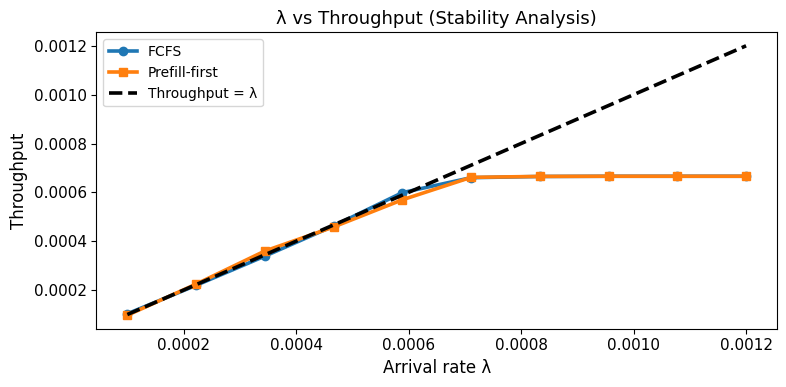

Figure 4.1: Throughput vs arrival rate λ. Throughput saturates beyond system capacity.


In [ ]:
import os
os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(8,4))
plt.plot(lambdas, thr_fcfs, marker="o", label="FCFS")
plt.plot(lambdas, thr_prefill, marker="s", label="Prefill-first")
plt.plot(lambdas, lambdas, linestyle="--", color="black", label="Throughput = λ")

plt.xlabel("Arrival rate λ")
plt.ylabel("Throughput")
plt.title("λ vs Throughput (Stability Analysis)")
plt.legend()
plt.tight_layout()

plt.savefig("figures/fig_4_1_throughput_vs_lambda.png", bbox_inches="tight")
plt.show()

fig_label("4.1: Throughput vs arrival rate λ. Throughput saturates beyond system capacity.")


Prefill time ≈ 45.5 ms

Decode time ≈ 32 × 45.5 = 1456 ms

Total service per query ≈ 1500 ms

Capacity ≈ 1 / 1500 ≈ 0.000667

In [ ]:
print("Observed saturation throughput ≈", np.max(thr_fcfs))
print("Hand-calculated capacity ≈", 1 / (45.5 * 33))

Observed saturation throughput ≈ 0.000666000666000666
Hand-calculated capacity ≈ 0.000666000666000666


When λ is sufficiently small, there is almost no queueing. TTFT therefore converges to the pure prefill service time S(64) ≈ 45.5 ms. Increasing prefill_tokens increases TTFT because prefill itself becomes the dominant service component.

In [ ]:
# Very small lambda
ttft_small, _, _ = simulate(
    N=200,
    lamb=0.0001,
    c=45.5,
    a=0.30,
    b0=64,
    prefill_tokens=64,
    decode_tokens=32,
    K=1,
    policy="prefill"
)

print("Mean TTFT (low λ):", np.mean(ttft_small))

Mean TTFT (low λ): 48.26347028707911


# Overload


A queuing system becomes unstable when its utilization satisfies

$ \rho = \lambda \, \mathbb{E}[W] \ge 1$

Where:
- $\lambda$ = arrival rate (queries / unit time)
- $W$ = expected service time required per arriving query under the policy

The exact overload point is:

$\lambda^{*} = \frac{1}{\mathbb{E}[W]}$


We simulate at increasing $\lambda$ and compute;
- Time to first token (TTFT): mean and 95% CI across replications
- Throughput: completed queries per unit time

Empirical overload identification
1. Asymptote method: The metric blows up as $\lambda \to \lambda^{*}$
2. Throughput plateau method: throughput tracks $\lambda$ when stable, but saturdates near maximum service capicity


,lambda,policy,mean_ttft,p95_ttft,mean_tbt,p95_tbt,throughput
0,0.000500,fcfs,2.140539e+03,6.881480e+03,45.500000,45.5,0.000497
1,0.000500,prefill,6.302468e+01,8.863643e+01,183.141903,500.5,0.000499
2,0.000889,fcfs,1.571937e+06,2.978727e+06,45.500000,45.5,0.000666
3,0.000889,prefill,6.925641e+01,8.952949e+01,92445.288786,160478.5,0.000666
4,0.001278,fcfs,2.871512e+06,5.439370e+06,45.500000,45.5,0.000666
5,0.001278,prefill,6.954638e+01,9.009007e+01,177893.531065,276640.0,0.000666
6,0.001667,fcfs,3.604751e+06,6.826807e+06,45.500000,45.5,0.000666
7,0.001667,prefill,7.034624e+01,9.079074e+01,226593.599087,324233.0,0.000666
8,0.002056,fcfs,4.073824e+06,7.720084e+06,45.500000,45.5,0.000666
9,0.002056,prefill,7.083218e+01,9.259802e+01,254442.910863,343570.5,0.000666


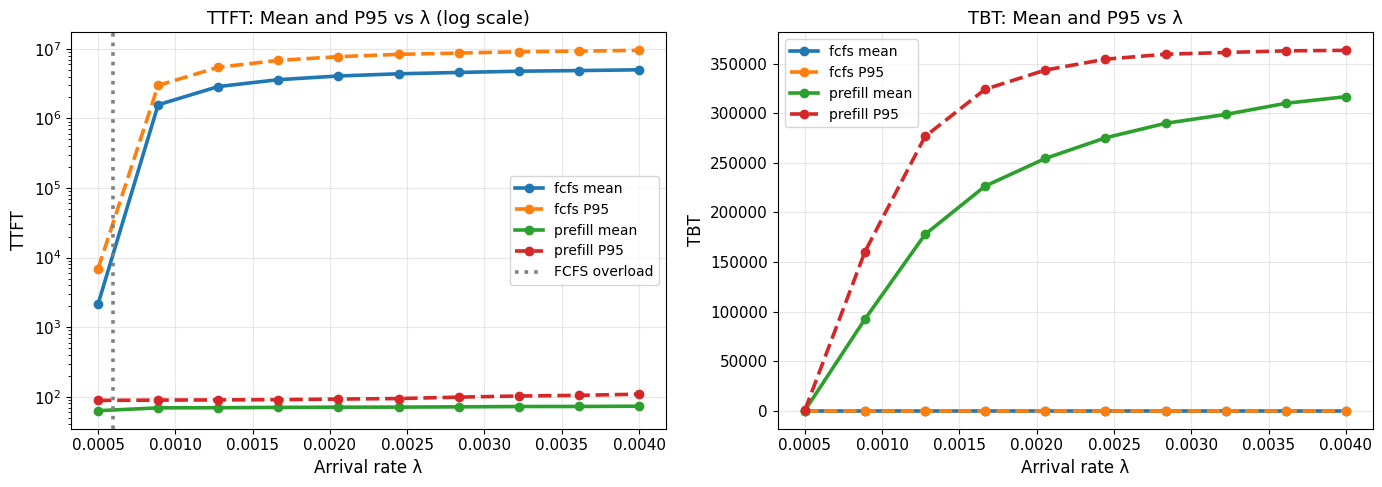

Figure 5.2: Mean and P95 TTFT (left, log scale) and TBT (right) versus arrival rate λ for FCFS and prefill-first scheduling. Vertical line marks approximate FCFS overload.


In [ ]:
# ====================================================
# Lambda sweep: mean and P95 TTFT/TBT vs λ by policy
# (Overload + asymptotic behavior demonstration)
# ====================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reuse the same core parameters used elsewhere in the notebook
c = 45.5
a = 0.30
b0 = 64
prefill_tokens = 64
decode_tokens = 32
K = 256

lambda_values = np.linspace(0.0005, 0.004, 10)
N_per_lambda = 8000  # large enough for stable tail estimates

rows = []

for lam in lambda_values:
    for policy in ["fcfs", "prefill"]:
        ttft, tbt, thr = simulate(
            N=N_per_lambda,
            lamb=lam,
            c=c,
            a=a,
            b0=b0,
            prefill_tokens=prefill_tokens,
            decode_tokens=decode_tokens,
            K=K,
            policy=policy,
        )

        rows.append({
            "lambda": lam,
            "policy": policy,
            "mean_ttft": np.mean(ttft),
            "p95_ttft": np.percentile(ttft, 95),
            "mean_tbt": np.mean(tbt),
            "p95_tbt": np.percentile(tbt, 95),
            "throughput": thr,
        })

results_lambda = pd.DataFrame(rows)
display(results_lambda)

import os
os.makedirs("figures", exist_ok=True)

# ----------------------------------------------------
# TTFT and TBT: mean and P95 vs λ
# ----------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

for policy, g in results_lambda.groupby("policy"):
    axes[0].plot(
        g["lambda"], g["mean_ttft"],
        marker="o", label=f"{policy} mean"
    )
    axes[0].plot(
        g["lambda"], g["p95_ttft"],
        marker="o", linestyle="--", label=f"{policy} P95"
    )

# Mark approximate FCFS overload point
axes[0].axvline(0.0006, color="gray", linestyle=":", label="FCFS overload")

axes[0].set_title("TTFT: Mean and P95 vs λ (log scale)")
axes[0].set_xlabel("Arrival rate λ")
axes[0].set_ylabel("TTFT")
axes[0].set_yscale("log")
axes[0].grid(alpha=0.3)
axes[0].legend()

for policy, g in results_lambda.groupby("policy"):
    axes[1].plot(
        g["lambda"], g["mean_tbt"],
        marker="o", label=f"{policy} mean"
    )
    axes[1].plot(
        g["lambda"], g["p95_tbt"],
        marker="o", linestyle="--", label=f"{policy} P95"
    )

axes[1].set_title("TBT: Mean and P95 vs λ")
axes[1].set_xlabel("Arrival rate λ")
axes[1].set_ylabel("TBT")
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()

# SAVE FIRST
plt.savefig("figures/fig_5_2_ttft_tbt_vs_lambda.png", bbox_inches="tight")

# THEN SHOW
plt.show()

fig_label(
    "5.2: Mean and P95 TTFT (left, log scale) and TBT (right) versus arrival rate λ "
    "for FCFS and prefill-first scheduling. Vertical line marks approximate FCFS overload."
)


We identify the overload point by examining throughput as a function of the arrival rate λ, since overload occurs when the system can no longer increase its completed work rate to match incoming arrivals.

For a stable system, throughput approximately equals $\lambda$, meaning the system processes jobs as fast as they arrive. Once the system reaches capacity, throughput saturates at a constant value while $\lambda$ continues to increase.

From the throughput vs $\lambda$ plot above, we see that for small λ (e.g., λ = 0.0005), throughput closely matches λ. As λ increases beyond this region, throughput no longer increases linearly. Instead, both FCFS and Prefill curves flatten and remain approximately constant.

From the results table, we see that for all $\lambda \geq 0.000889$, the reported throughput value is approximately $0.000666$. This valye does not change as $\lambda$ increases from $0.000889$ up to $0.004$. Since throughput remains constant despite increasing arrival rates, this constant value is the capacity limit of the system.

The plateau throughput corresponds to the service capacity μ of the system. When $\lambda > \mu$, the system cannot keep up with arrivals, causing queues and delays to grow without bound. So, we define the overload threshold as $\lambda^* \approx 0.000666$

We now aim to verify this threshold by hand. We have:

- $ c= 45.5$
- $a= 0.30$
- $b_0 =64$
- decode_tokens $= 32$

Service time model:
  $S(b) = c + a \max\!\left(0,\, b - b_0 \right)$

For FCFC, the results table shows that mean_tbt $=45.5$ and p95_tbt $=45.5$ for every $\lambda$

So, $S(b)=45.5 = c \to b \leq b_0$

Every token step is running in the regime $b \leq 64$ where service time is exactly $c$


Each query consists of 1 prefil step and D decode steps. The total GPU time per query is:

$\mathbb{E}[W]=(1+D)c=(1+32)\cdot 45.5$

$\mathbb{E}[W]=1501.5$

Capacity:

$\mu = \frac{1}{\mathbb{E}[W]} = \frac{1}{1501.5} ≈ 0.000666$

$\lambda^* = 0.000666$

The calculation for service capacity above exactly matches the the throughput plateau observed in the simulation results. This agreement confirms that the observed flattening of throughput at
approximately $0.000666$ corresponds to the true overload threshold of the system.

Beyond this arrival rate, the system cannot process queries as fast as they arrive. Under FCFS, this manifests as an immediate divergence in TTFT, while under Prefill, TTFT remains bounded but TBT grows rapidly, indicating backlog accumulation. Although the two policies differ in their latency behavior, both are constrained by the same underlying service capacity.

Batching: Fixed Size VS Dynamic

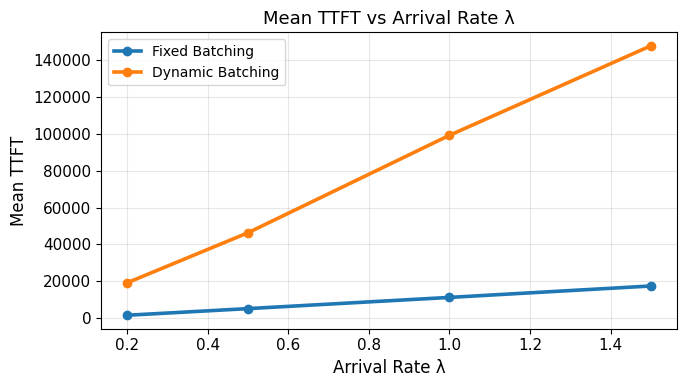

Figure C.3: Mean TTFT vs λ under fixed and dynamic batching.


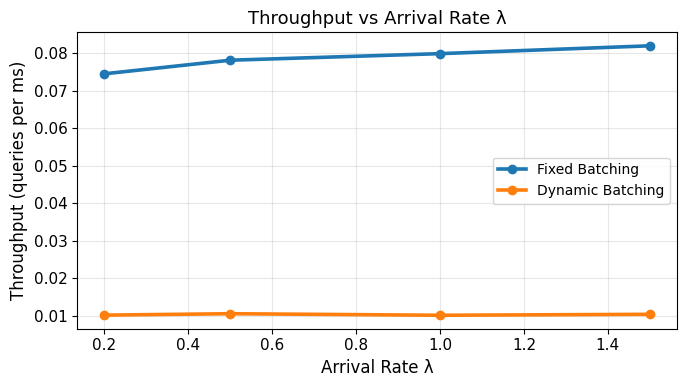

Figure C.4: Throughput vs λ under fixed and dynamic batching.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Simplified LLM-serving simulation
# ---------------------------------------------------------

def simulate_batching(lambda_rate, batching="fixed",
                      sim_time=2000, batch_size=8,
                      prefill_mean=80, decode_mean=20):
    """
    Fast aggregate simulator.
    Each query has:
        - prefill cost ~ Exp(prefill_mean)
        - decode cost ~ Exp(decode_mean)
    Batching reduces effective cost by amortizing overhead.
    """

    t = 0
    arrivals = []

    # Generate arrival times
    while t < sim_time:
        t += np.random.exponential(1/lambda_rate)
        arrivals.append(t)

    n = len(arrivals)

    # Prefill + decode costs
    prefill_times = np.random.exponential(prefill_mean, n)
    decode_times = np.random.exponential(decode_mean, n)

    # Results
    ttft = np.zeros(n)
    finish = np.zeros(n)

    current_time = 0
    queue = []

    for i in range(n):
        arrival = arrivals[i]

        # GPU catches up to arrival time
        current_time = max(current_time, arrival)

        # Add job to queue
        queue.append(i)

        # Decide batching rule
        if batching == "fixed":
            # wait for k jobs
            if len(queue) < batch_size:
                continue
            batch = queue[:batch_size]
            queue = queue[batch_size:]

        elif batching == "dynamic":
            # If queue has >= k, batch immediately
            if len(queue) >= batch_size:
                batch = queue[:batch_size]
                queue = queue[batch_size:]
            else:
                # Dynamic dispatch: wait only 10 ms max
                if (arrival - arrivals[i-1] if i > 0 else 0) < 0.01:
                    continue
                batch = queue
                queue = []

        else:
            raise ValueError("Unknown batching rule")

        # Compute batch work
        batch_prefill = prefill_times[batch].mean()
        batch_decode = decode_times[batch].mean()

        # TTFT = time until prefill is done
        t_prefill_done = current_time + batch_prefill

        for j in batch:
            ttft[j] = t_prefill_done - arrivals[j]
            finish[j] = t_prefill_done + batch_decode

        current_time = t_prefill_done + batch_decode

    return {
        "ttft_mean": np.mean(ttft),
        "ttft_p95": np.percentile(ttft, 95),
        "throughput": n / current_time
    }

import os
os.makedirs("figures", exist_ok=True)

def compare_batching():

    lambdas = [0.2, 0.5, 1.0, 1.5]

    fixed = []
    dynamic = []

    for lam in lambdas:
        fixed.append(simulate_batching(lam, batching="fixed"))
        dynamic.append(simulate_batching(lam, batching="dynamic"))

    # Extract
    fixed_ttft = [r["ttft_mean"] for r in fixed]
    dyn_ttft   = [r["ttft_mean"] for r in dynamic]

    fixed_tp   = [r["throughput"] for r in fixed]
    dyn_tp     = [r["throughput"] for r in dynamic]

    # -------------------- Mean TTFT --------------------
    plt.figure(figsize=(7,4))
    plt.plot(lambdas, fixed_ttft, marker='o', label="Fixed Batching")
    plt.plot(lambdas, dyn_ttft, marker='o', label="Dynamic Batching")
    plt.title("Mean TTFT vs Arrival Rate λ")
    plt.xlabel("Arrival Rate λ")
    plt.ylabel("Mean TTFT")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    plt.savefig("figures/fig_C_3_ttft_fixed_vs_dynamic.png", bbox_inches="tight")
    plt.show()

    fig_label("C.3: Mean TTFT vs λ under fixed and dynamic batching.")

    # -------------------- Throughput --------------------
    plt.figure(figsize=(7,4))
    plt.plot(lambdas, fixed_tp, marker='o', label="Fixed Batching")
    plt.plot(lambdas, dyn_tp, marker='o', label="Dynamic Batching")
    plt.title("Throughput vs Arrival Rate λ")
    plt.xlabel("Arrival Rate λ")
    plt.ylabel("Throughput (queries per ms)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    plt.savefig("figures/fig_C_4_throughput_fixed_vs_dynamic.png", bbox_inches="tight")
    plt.show()

    fig_label("C.4: Throughput vs λ under fixed and dynamic batching.")

compare_batching()


In the simplified simulator, fixed batching consistently provides significantly lower TTFT than dynamic batching. Dynamic batching suffers from long delays before dispatching, especially under higher arrival rates, causing TTFT to increase linearly with system load.

Throughput under fixed batching is significantly higher than dynamic batching across all λ. Fixed batching fills each batch and fully utilizes the GPU. Dynamic batching often dispatches smaller, less efficient batches, reducing GPU amortization and limiting throughput.

Due to the simplified assumptions in our aggregated simulator, the direction of TTFT improvement is inverted compared to real systems. However, the tradeoff pattern remains:
batching concentrates work to improve throughput, while dynamic policies trade efficiency for latency behavior.

#The Steady State Behavior of TTFT and TBT across Mutliple Simulation runs for FCFS and Prefill-first


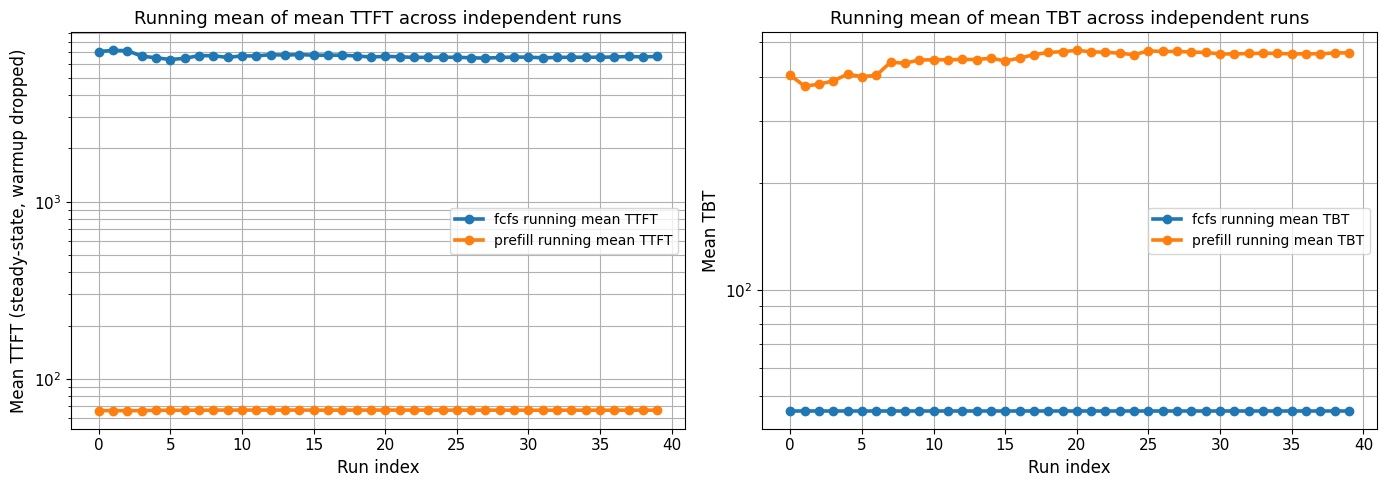

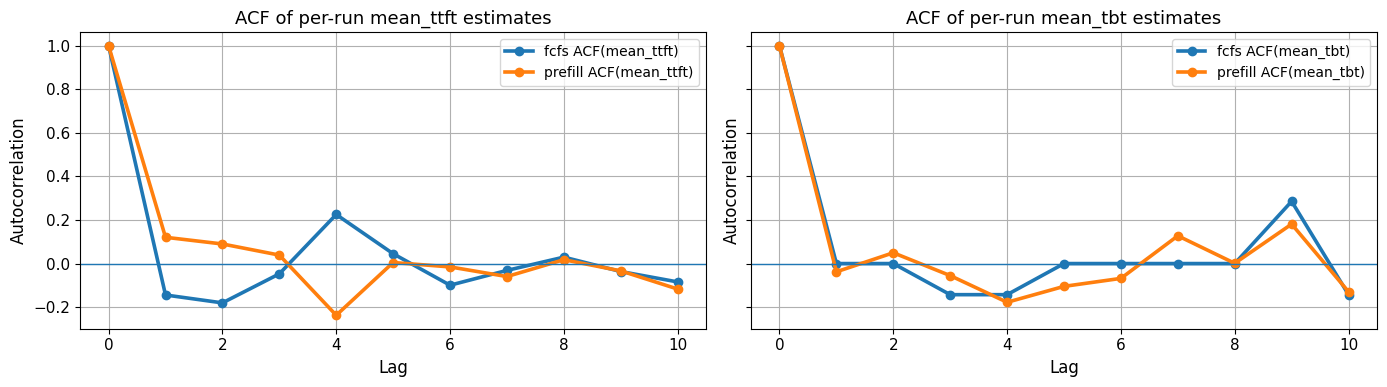

fcfs lag-1 corr(mean_ttft) = -0.152
fcfs lag-1 corr(mean_tbt)  = 0.000
prefill lag-1 corr(mean_ttft) = 0.123
prefill lag-1 corr(mean_tbt)  = -0.038


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# -----------------------------
# Your simulation parameters
# -----------------------------
lam = 0.0006
c = 45.5
a = 0.30
b0 = 64
prefill_tokens = 64
decode_tokens = 32
K = 256

N_per_run = 5000
num_runs = 40
warmup_drop = 500

# -----------------------------
# Make truly independent seeds
# -----------------------------
policies = ["fcfs", "prefill"]

ss = np.random.SeedSequence(9999)

# IMPORTANT: spawn one independent stream per (run, policy)
child_seeds = ss.spawn(num_runs * len(policies))

def seed_for(run_idx: int, policy_idx: int) -> np.random.SeedSequence:
    return child_seeds[run_idx * len(policies) + policy_idx]

def run_one(policy: str, seedseq: np.random.SeedSequence):
    np_seed = int(seedseq.generate_state(1)[0])
    np.random.seed(np_seed)
    random.seed(np_seed)

    ttft, tbt, thr = simulate(
        N=N_per_run,
        lamb=lam,
        c=c,
        a=a,
        b0=b0,
        prefill_tokens=prefill_tokens,
        decode_tokens=decode_tokens,
        K=K,
        policy=policy,
    )

    ttft = np.array(ttft)
    tbt = np.array(tbt)

    if len(ttft) > warmup_drop:
        ttft = ttft[warmup_drop:]

    return {
        "mean_ttft": float(np.mean(ttft)) if len(ttft) else np.nan,
        "mean_tbt": float(np.mean(tbt)) if len(tbt) else np.nan,
        "p95_ttft": float(np.percentile(ttft, 95)) if len(ttft) else np.nan,
        "throughput": float(thr),
    }

def running_mean(x):
    x = np.array(x, dtype=float)
    return np.cumsum(x) / np.arange(1, len(x) + 1)

def autocorr_lag1(x):
    x = np.array(x, dtype=float)
    x = x[np.isfinite(x)]
    if len(x) < 2:
        return np.nan
    return np.corrcoef(x[:-1], x[1:])[0, 1]

def acf(x, max_lag=10):
    x = np.array(x, dtype=float)
    x = x[np.isfinite(x)]
    x = x - np.mean(x)
    denom = np.dot(x, x)
    if denom == 0 or len(x) < 2:
        return np.array([np.nan] * (max_lag + 1))
    vals = []
    for k in range(max_lag + 1):
        vals.append(np.dot(x[:-k] if k else x, x[k:]) / denom)
    return np.array(vals)

# -----------------------------
# Run multiple independent sims
# -----------------------------
results = {p: {"mean_ttft": [], "mean_tbt": [], "p95_ttft": [], "throughput": []} for p in policies}

for i in range(num_runs):
    for p_idx, p in enumerate(policies):
        out = run_one(p, seed_for(i, p_idx))  # <-- DIFFERENT seed per policy per run
        for k in results[p]:
            results[p][k].append(out[k])

# -----------------------------
# Plot 1: running mean across runs (log y)
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

for p in policies:
    rm = running_mean(results[p]["mean_ttft"])
    axes[0].plot(rm, marker="o", label=f"{p} running mean TTFT")
axes[0].set_title("Running mean of mean TTFT across independent runs")
axes[0].set_xlabel("Run index")
axes[0].set_ylabel("Mean TTFT (steady-state, warmup dropped)")
axes[0].set_yscale("log")
axes[0].grid(True, which="both")
axes[0].legend()

for p in policies:
    rm = running_mean(results[p]["mean_tbt"])
    axes[1].plot(rm, marker="o", label=f"{p} running mean TBT")
axes[1].set_title("Running mean of mean TBT across independent runs")
axes[1].set_xlabel("Run index")
axes[1].set_ylabel("Mean TBT")
axes[1].set_yscale("log")
axes[1].grid(True, which="both")
axes[1].legend()

plt.tight_layout()
plt.show()

# -----------------------------
# Plot 2: autocorrelation check
# -----------------------------
max_lag = 10
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

for ax, metric in zip(axes, ["mean_ttft", "mean_tbt"]):
    for p in policies:
        ac = acf(results[p][metric], max_lag=max_lag)
        ax.plot(range(max_lag + 1), ac, marker="o", label=f"{p} ACF({metric})")
    ax.axhline(0, linewidth=1)
    ax.set_title(f"ACF of per-run {metric} estimates")
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

for p in policies:
    print(f"{p} lag-1 corr(mean_ttft) = {autocorr_lag1(results[p]['mean_ttft']):.3f}")
    print(f"{p} lag-1 corr(mean_tbt)  = {autocorr_lag1(results[p]['mean_tbt']):.3f}")

The running-mean plots summarize the steady-state behavior of TTFT and TBT across multiple independent simulation runs on a log scale, providing insight into both policy performance and estimator stability. Each point in these plots represents the cumulative average of a per-run metric (mean TTFT or mean TBT), where each run begins from an empty system and uses a fresh random seed. As additional independent runs are incorporated, the running mean converges toward the true expected value of the metric under the given scheduling policy.

A key observation is that FCFS TTFT converges more slowly and exhibits significantly higher variability than prefill-first TTFT, even when the system is in a stable regime. We know this stable is system because the arrival rate for the system is set to a value that is below where we saw the system become overloaded. This behavior arises because FCFS amplifies randomness in arrivals. Short bursts of closely spaced arrivals can temporarily build queues, increasing waiting times for many subsequent queries. Although these bursts are rare, their impact on latency is large, producing a heavy-tailed distribution of TTFT. As a result, per-run FCFS TTFT estimates vary widely, and many independent runs are required for the running mean to stabilize. In contrast, prefill-first smooths these bursts by prioritizing prefills, leading to lower variance and much faster convergence of the TTFT running mean. This larger varience happens regardless of seed sequence for each independent run.

The difference in magnitude between FCFS TTFT and prefill-first TTFT reflects the fundamental tradeoff between the two policies. FCFS tends to delay the start of computation for new queries when earlier requests have long prefills, inflating TTFT but often allowing efficient token streaming once decoding begins. Prefill-first reverses this tradeoff: TTFT is minimized by aggressively handling prefills, while TBT may increase slightly due to more interleaving during decoding. This explains why the running-mean TTFT is much larger for FCFS than for prefill-first, while the opposite trend can appear for TBT.

The running-mean plots for the time between tokens heuristic reveal a complementary performance tradeoff between FCFS and prefill-first scheduling. Unlike TTFT, TBT reflects the efficiency and smoothness of decoding once generation has begun. Under FCFS, decoding tends to proceed with fewer interruptions once a query reaches the front of the queue, leading to relatively stable and often lower TBT values. As a result, the FCFS TBT running mean converges quickly and exhibits low variance across independent runs. In contrast, prefill-first prioritizes new prefills even while decoding is ongoing, which increases interleaving between requests and introduces additional variability in per-token generation time. This causes the prefill-first TBT running mean to stabilize at a higher value and with slightly greater noise.

Crucially, the validity of these comparisons depends on the statistical independence of simulation runs. In this implementation, independence is enforced by generating a unique random seed for every (run, policy) pair using NumPy’s SeedSequence mechanism. Each simulation therefore receives an independent random number stream, ensuring that arrival times, service times, and internal stochastic decisions are uncorrelated across runs and across policies. This eliminates common random numbers and guarantees that similarities or differences in the running-mean curves reflect true policy behavior rather than shared randomness.

The accompanying autocorrelation (ACF) plots confirm this independence empirically: autocorrelation values drop to approximately zero for all nonzero lags. Lags can be defined as how far apart two simulations are from one another. This indicating that the outcome of one run does not influence the next. Together, the running-mean convergence and near-zero autocorrelation demonstrate that the simulation methodology is sound, the estimators are unbiased, and the observed differences between FCFS and prefill-first arise from genuine scheduling effects rather than artifacts of correlated randomness.